# IMPORT LIBRARY

In [150]:
# Data Manipulation and Graph
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score

In [151]:
df= pd.read_csv('csv/Regresi A5_final.csv')
df.head(10)

,tahun,bulan,tanggal,stasiun,karbon_monoksida
0,2024,1,1,DKI5 Kebon Jeruk Jakarta Barat,18.0
1,2024,1,2,DKI5 Kebon Jeruk Jakarta Barat,9.0
2,2024,1,3,DKI5 Kebon Jeruk Jakarta Barat,7.0
3,2024,1,4,DKI5 Kebon Jeruk Jakarta Barat,10.0
4,2024,1,5,DKI5 Kebon Jeruk Jakarta Barat,15.0
5,2024,1,6,DKI5 Kebon Jeruk Jakarta Barat,12.0
6,2024,1,7,DKI5 Kebon Jeruk Jakarta Barat,23.0
7,2024,1,8,DKI5 Kebon Jeruk Jakarta Barat,12.0
8,2024,1,9,DKI5 Kebon Jeruk Jakarta Barat,18.0
9,2024,1,10,DKI5 Kebon Jeruk Jakarta Barat,11.0


# DATA SPLITTING

In [152]:
import os
def data_spliting (percent):
    df = pd.read_csv('csv/Regresi A5_final.csv')
    split_point = int(len(df) * percent)
    train = df[:split_point]
    test = df[split_point:]

    file_path_train = os.path.join('csv', f'data_train_{percent}.csv')
    file_path_test = os.path.join('csv', f'data_test_{percent}.csv')

    train.to_csv(file_path_train, index=False)
    test.to_csv(file_path_test, index=False)
    
data_spliting(0.7) #70%
data_spliting(0.8) #80%

# MODEL TRAINING

In [153]:
def create_dataset(series, time_step=4, feature_name="karbon_monoksida", recent_first=True):
    """
    series: array/list 1D atau 2D
    recent_first=True  -> kolom: [lag1=t-1, lag2=t-2, ...]
    recent_first=False -> kolom: [t-4, t-3, t-2, t-1] (seperti punyamu sekarang)
    """
    s = np.asarray(series).ravel()
    X, y = [], []
    for i in range(len(s) - time_step):
        window = s[i:i+time_step]               # [t-4, t-3, t-2, t-1] Testing
        if recent_first:
            window = window[::-1]               # balik: [t-1, t-2, t-3, t-4]
        X.append(window)
        y.append(s[i+time_step])                # target t

    X = np.array(X)
    y = np.array(y)
    cols = [f"{feature_name}_lag{j}" for j in range(1, time_step+1)]
    return pd.DataFrame(X, columns=cols), pd.Series(y, name=feature_name)

time_step = 4

# ============ Skenario 70% ============
train_df_70 = pd.read_csv("csv/data_train_0.7.csv")
test_df_70  = pd.read_csv("csv/data_test_0.7.csv")

y_train_raw_70 = train_df_70["karbon_monoksida"].values
y_test_raw_70  = test_df_70["karbon_monoksida"].values

X_train_70, y_train_70 = create_dataset(y_train_raw_70, time_step, "karbon_monoksida")
X_test_70,  y_test_70  = create_dataset(y_test_raw_70,  time_step, "karbon_monoksida")

# ============ Skenario 80% ============
train_df_80 = pd.read_csv("csv/data_train_0.8.csv")
test_df_80  = pd.read_csv("csv/data_test_0.8.csv")

y_train_raw_80 = train_df_80["karbon_monoksida"].values
y_test_raw_80  = test_df_80["karbon_monoksida"].values

X_train_80, y_train_80 = create_dataset(y_train_raw_80, time_step, "karbon_monoksida")
X_test_80,  y_test_80  = create_dataset(y_test_raw_80,  time_step, "karbon_monoksida")

print("70%:", X_train_70.shape, X_test_70.shape)
print("80%:", X_train_80.shape, X_test_80.shape)

# Contoh preview
print("\nX_train_70 head:")
display(X_train_70.head())
print("\ny_train_70 head:")
display(y_train_70.head())

# tempat nyimpen model/rekap
trained_models_70, trained_models_80 = {}, {}
rows_70, rows_80 = [], []


70%: (378, 4) (161, 4)
80%: (433, 4) (106, 4)

X_train_70 head:


,karbon_monoksida_lag1,karbon_monoksida_lag2,karbon_monoksida_lag3,karbon_monoksida_lag4
0,10.0,7.0,9.0,18.0
1,15.0,10.0,7.0,9.0
2,12.0,15.0,10.0,7.0
3,23.0,12.0,15.0,10.0
4,12.0,23.0,12.0,15.0



y_train_70 head:


0    15.0
1    12.0
2    23.0
3    12.0
4    18.0
Name: karbon_monoksida, dtype: float64

## Linear Regression

### S1: 70/30

In [154]:
# latih Linear Regression (70%)
lr_70 = LinearRegression()
lr_70.fit(X_train_70, y_train_70)

# masukkan ke dict model terlatih 70% (BIAR TERBACA OLEH CELL MAE)
trained_models_70["Linear Regression"] = lr_70


### S2: 80/20

In [155]:
# latih Linear Regression (80%)
lr_80 = LinearRegression()
lr_80.fit(X_train_80, y_train_80)

# masukkan ke dict model terlatih 80% (BIAR TERBACA OLEH CELL MAE)
trained_models_80["Linear Regression"] = lr_80

## Gradient Boosting

### S1: 70/30

### S2: 80/20

## ADA Boost

In [156]:
def plot_pred_vs_actual(y_true, y_pred, title="Prediction vs Actual"):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="Actual", marker='o', linestyle='-', alpha=0.8)
    plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', alpha=0.8)
    plt.title(title)
    plt.xlabel("Time index")
    plt.ylabel("Target value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

### S1: 70/30

In [157]:
# Training
start_time = time.time()
adb_model70 = AdaBoostRegressor(learning_rate= 0.002, random_state=42, n_estimators=100)
adb_model70.fit(X_train_70, y_train_70)
end_time = time.time()
trained_models_70['Ada Boost'] = adb_model70

trt_adb70 = end_time - start_time
print(f"Training time for ADB 70/30: {trt_adb70:.4f} seconds")

# Predict
ypred_adb70= adb_model70.predict(X_test_70)

Training time for ADB 70/30: 0.1970 seconds


In [158]:
trained_models_70

{'Linear Regression': LinearRegression(),
 'Ada Boost': AdaBoostRegressor(learning_rate=0.002, n_estimators=100, random_state=42)}

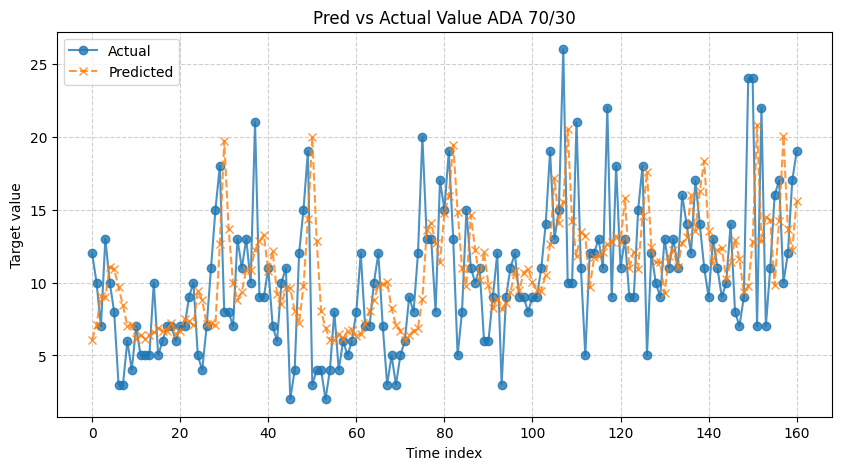

In [159]:
plot_pred_vs_actual(y_test_70, ypred_adb70, "Pred vs Actual Value ADA 70/30")

### S2: 80/20

In [160]:
# Training
start_time = time.time()
adb_model80 = AdaBoostRegressor(learning_rate= 0.002, random_state=42, n_estimators=100)
adb_model80.fit(X_train_80, y_train_80)
end_time = time.time()
trained_models_80['Ada Boost'] = adb_model80

trt_adb80 = end_time - start_time
print(f"Training time for ADB 80/20: {trt_adb80:.4f} seconds")

# Predict
ypred_adb80= adb_model80.predict(X_test_80)

Training time for ADB 80/20: 0.2013 seconds


In [161]:
trained_models_80

{'Linear Regression': LinearRegression(),
 'Ada Boost': AdaBoostRegressor(learning_rate=0.002, n_estimators=100, random_state=42)}

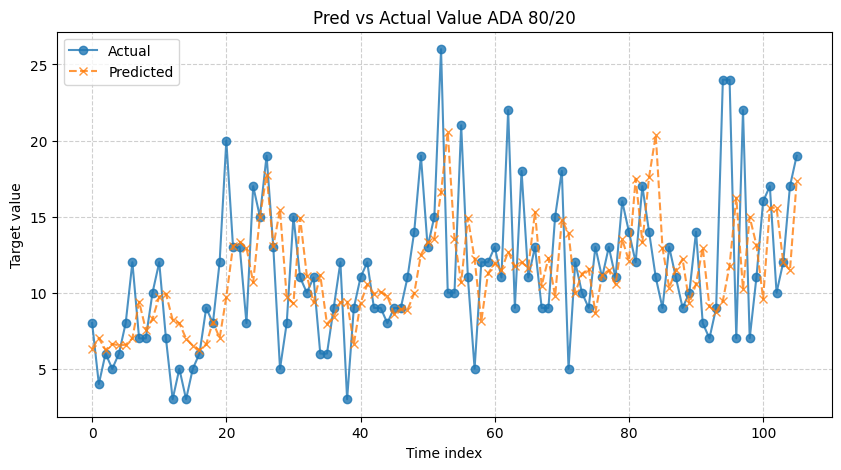

In [162]:
plot_pred_vs_actual(y_test_80, ypred_adb80, "Pred vs Actual Value ADA 80/20")

## XG Boost

### S1: 70/30

In [163]:
# Training
start_time = time.time()
xgb_model70 = XGBRegressor(learning_rate= 0.05, random_state=42, n_estimators=1000, max_depth= 7, reg_lambda=5)
xgb_model70.fit(X_train_70, y_train_70)
end_time = time.time()
trained_models_70['XG Boost'] = xgb_model70

trt_xgb70 = end_time - start_time
print(f"Training time for XGB 70/30: {trt_xgb70:.4f} seconds")

# Predict
ypred_xgb70= xgb_model70.predict(X_test_70)

Training time for XGB 70/30: 1.5371 seconds


In [164]:
trained_models_70

{'Linear Regression': LinearRegression(),
 'Ada Boost': AdaBoostRegressor(learning_rate=0.002, n_estimators=100, random_state=42),
 'XG Boost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)}

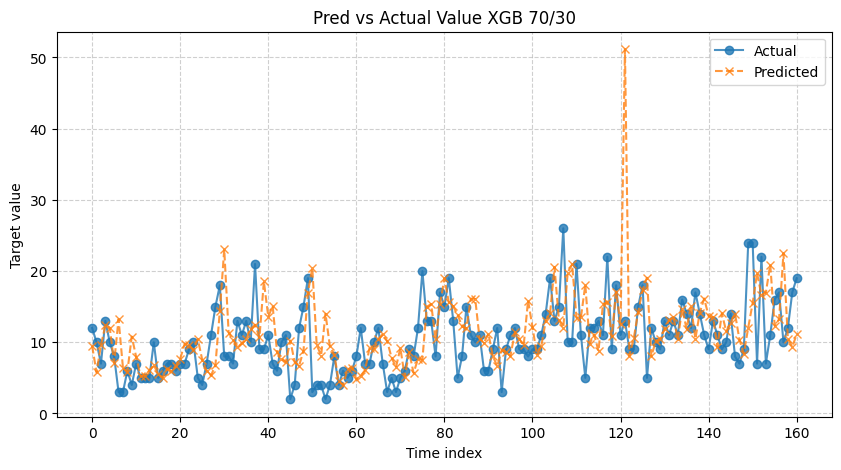

In [165]:
plot_pred_vs_actual(y_test_70, ypred_xgb70, "Pred vs Actual Value XGB 70/30")

### S2: 80/20

In [166]:
# Training
start_time = time.time()
xgb_model80 = XGBRegressor(learning_rate= 0.05, random_state=42, n_estimators=100, max_depth= 7, reg_lambda=5)
xgb_model80.fit(X_train_80, y_train_80)
end_time = time.time()
trained_models_80['XG Boost'] = xgb_model80

trt_xgb80 = end_time - start_time
print(f"Training time for XGB 80/30: {trt_xgb80:.4f} seconds")

# Predict
ypred_xgb80= xgb_model80.predict(X_test_80)

Training time for XGB 80/30: 0.1804 seconds


In [167]:
trained_models_80

{'Linear Regression': LinearRegression(),
 'Ada Boost': AdaBoostRegressor(learning_rate=0.002, n_estimators=100, random_state=42),
 'XG Boost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)}

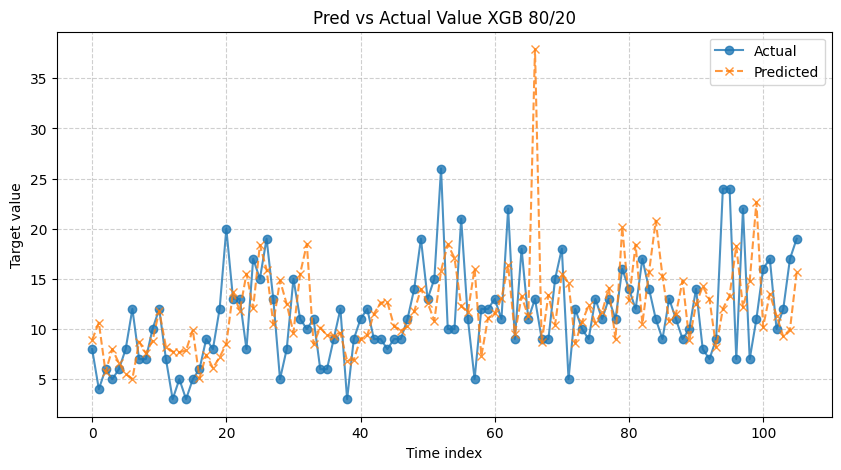

In [168]:
plot_pred_vs_actual(y_test_80, ypred_xgb80, "Pred vs Actual Value XGB 80/20")

## CAT Boost

### S1: 70/30

### S2: 80/20

## SVR

### S1: 70/30

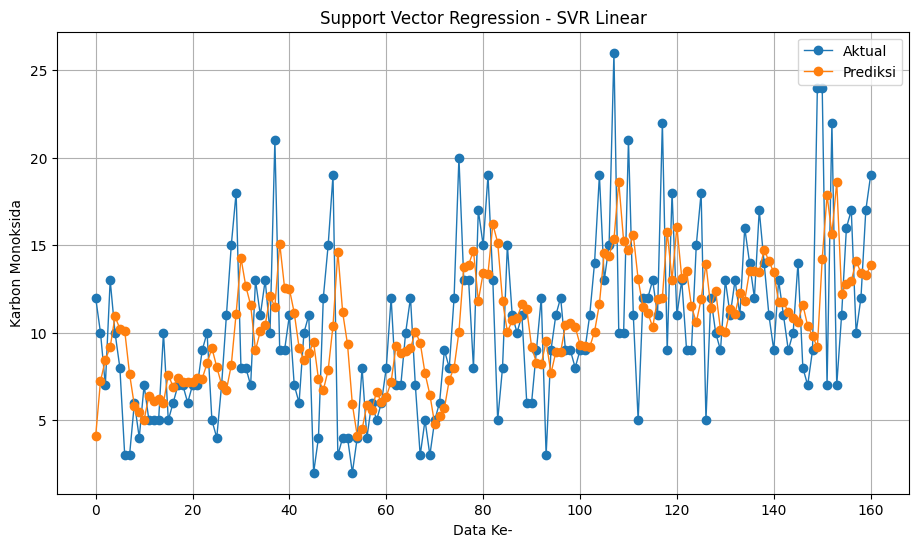

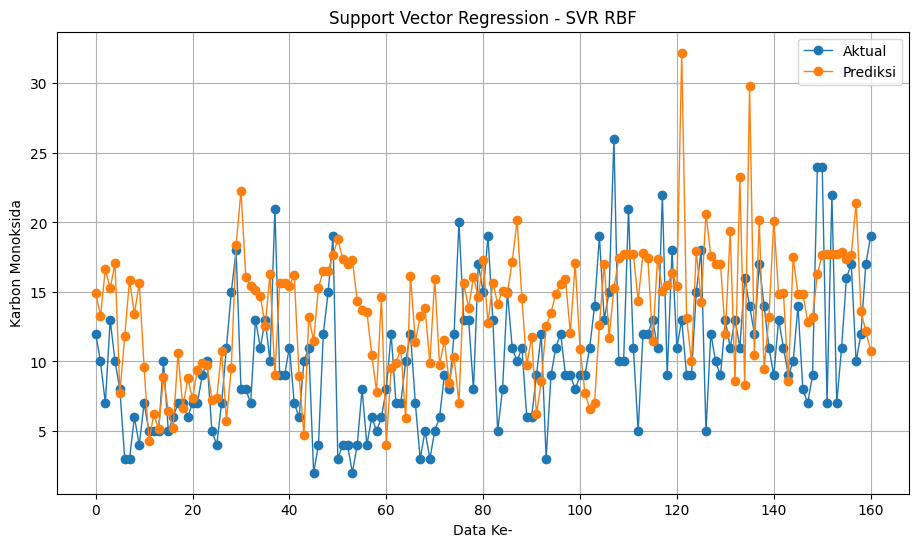

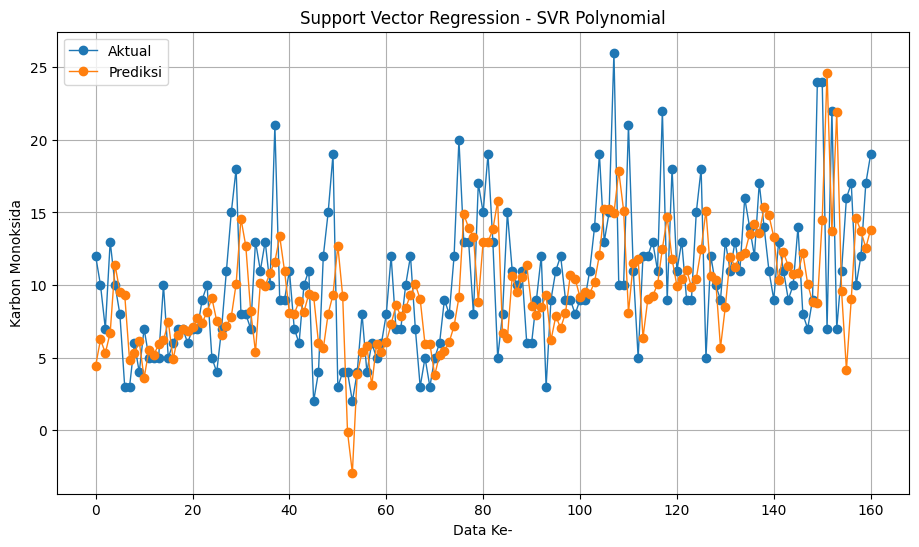

         Model                                                   Parameter Kernel  Train Time (s)
    SVR Linear                                 kernel=linear, C=10.0, epsilon=0.1          0.4704
       SVR RBF                        kernel=rbf, C=100.0, epsilon=0.1, gamma=0.1          0.0701
SVR Polynomial kernel=poly, degree=3, C=50.0, epsilon=0.1, gamma=scale, coef0=1.0          6.4002


In [169]:
X_train, y_train = X_train_70, y_train_70
X_test, y_test   = X_test_70,  y_test_70

# ============ Definisi model ============
models = {
    "SVR Linear": SVR(kernel="linear", C=10.0, epsilon=0.1),
    "SVR RBF":    SVR(kernel="rbf", C=100.0, gamma=0.1, epsilon=0.1),
    "SVR Polynomial": SVR(kernel="poly", degree=3, C=50.0, gamma="scale", coef0=1.0, epsilon=0.1),
}

rows_70.clear()

for name, model in models.items():
    # param string sesuai kernel
    params = model.get_params()
    if model.kernel == "linear":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}"
    elif model.kernel == "rbf":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}, gamma={params['gamma']}"
    elif model.kernel == "poly":
        param_str = (f"kernel={params['kernel']}, degree={params['degree']}, "
                     f"C={params['C']}, epsilon={params['epsilon']}, "
                     f"gamma={params['gamma']}, coef0={params['coef0']}")
    else:
        param_str = str(params)

    # waktu training
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    # simpan model terlatih
    trained_models_70[name] = model

    rows_70.append({
        "Model": name,
        "Parameter Kernel": param_str,
        "Train Time (s)": round(train_time, 4)
    })

    # plot
    y_pred = model.predict(X_test)
    plt.figure(figsize=(11,6))
    plt.plot(y_test, label="Aktual", marker='o', linewidth=1)
    plt.plot(y_pred, label="Prediksi", marker='o', linewidth=1)
    plt.title(f"Support Vector Regression - {name}")
    plt.xlabel("Data Ke-")
    plt.ylabel("Karbon Monoksida")
    plt.legend()
    plt.grid()
    plt.show()

# tabel train time
results_df = pd.DataFrame(rows_70)
print(results_df.to_string(index=False))

### S2: 80/20

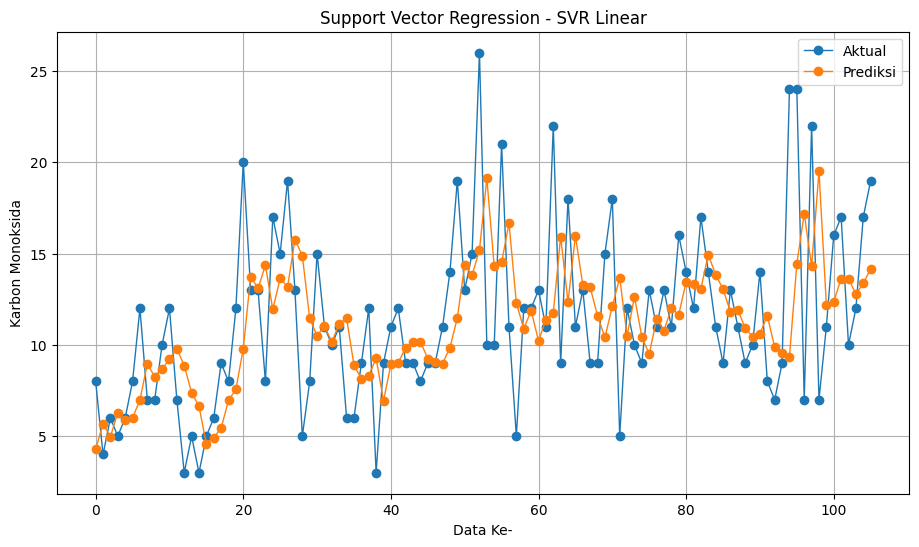

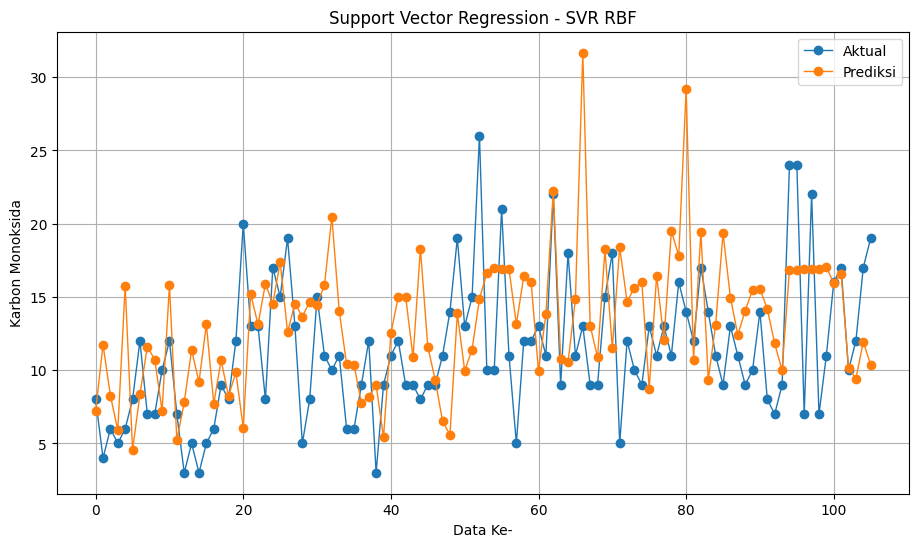

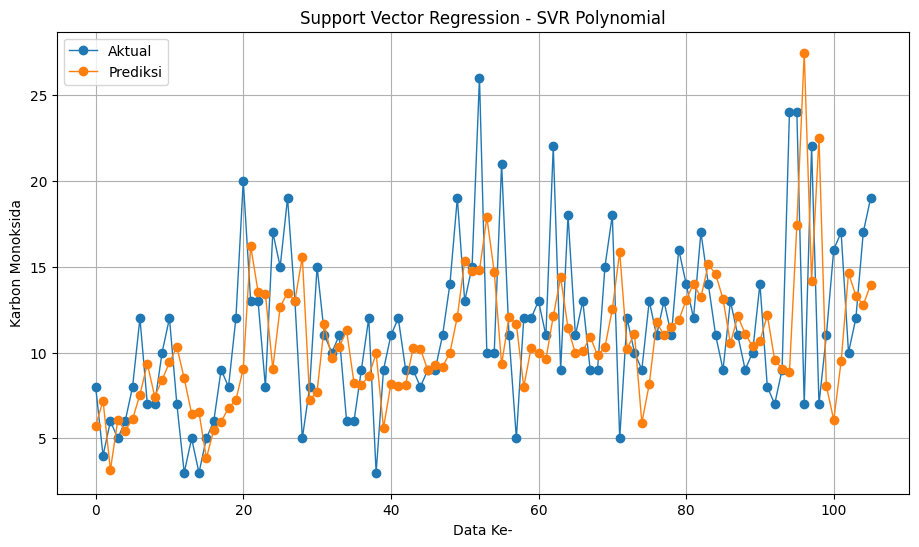

         Model                                                   Parameter Kernel  Train Time (s)
    SVR Linear                                 kernel=linear, C=10.0, epsilon=0.1          0.3635
       SVR RBF                        kernel=rbf, C=100.0, epsilon=0.1, gamma=0.1          0.1089
SVR Polynomial kernel=poly, degree=3, C=50.0, epsilon=0.1, gamma=scale, coef0=1.0          3.8349


In [170]:
X_train, y_train = X_train_80, y_train_80
X_test, y_test   = X_test_80,  y_test_80

# ============ Definisi model ============
models = {
    "SVR Linear": SVR(kernel="linear", C=10.0, epsilon=0.1),
    "SVR RBF":    SVR(kernel="rbf", C=100.0, gamma=0.1, epsilon=0.1),
    "SVR Polynomial": SVR(kernel="poly", degree=3, C=50.0, gamma="scale", coef0=1.0, epsilon=0.1),
}

rows_80.clear()

for name, model in models.items():
    # param string sesuai kernel
    params = model.get_params()
    if model.kernel == "linear":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}"
    elif model.kernel == "rbf":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}, gamma={params['gamma']}"
    elif model.kernel == "poly":
        param_str = (f"kernel={params['kernel']}, degree={params['degree']}, "
                     f"C={params['C']}, epsilon={params['epsilon']}, "
                     f"gamma={params['gamma']}, coef0={params['coef0']}")
    else:
        param_str = str(params)

    # waktu training
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    # simpan model terlatih
    trained_models_80[name] = model

    rows_80.append({
        "Model": name,
        "Parameter Kernel": param_str,
        "Train Time (s)": round(train_time, 4)
    })

    # plot
    y_pred = model.predict(X_test)
    plt.figure(figsize=(11,6))
    plt.plot(y_test, label="Aktual", marker='o', linewidth=1)
    plt.plot(y_pred, label="Prediksi", marker='o', linewidth=1)
    plt.title(f"Support Vector Regression - {name}")
    plt.xlabel("Data Ke-")
    plt.ylabel("Karbon Monoksida")
    plt.legend()
    plt.grid()
    plt.show()

# tabel train time
results_df = pd.DataFrame(rows_80)
print(results_df.to_string(index=False))

# MODEL EVALUATION

## MAE

### S1: 70/30

In [171]:
rows_mae_70 = []

def evaluate_mae(name, model, X_test, y_test, rows, scenario):
    from sklearn.metrics import mean_absolute_error
    y_pred = model.predict(X_test)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAE": round(mean_absolute_error(y_test, y_pred), 4)
    })

for name, model in trained_models_70.items():
    evaluate_mae(name, model, X_test_70, y_test_70, rows_mae_70, "70%")

import pandas as pd
df_mae_70 = pd.DataFrame(rows_mae_70)
print(df_mae_70.to_string(index=False))

Scenario         Algoritma    MAE
     70% Linear Regression 3.6896
     70%         Ada Boost 3.6590
     70%          XG Boost 4.1259
     70%        SVR Linear 3.5156
     70%           SVR RBF 5.4962
     70%    SVR Polynomial 3.7244


### S2: 80/20

In [172]:
rows_mae_80 = []

def evaluate_mae(name, model, X_test, y_test, rows, scenario):
    from sklearn.metrics import mean_absolute_error
    y_pred = model.predict(X_test)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAE": round(mean_absolute_error(y_test, y_pred), 4)
    })

for name, model in trained_models_80.items():
    evaluate_mae(name, model, X_test_80, y_test_80, rows_mae_80, "80%")

import pandas as pd
df_mae_80 = pd.DataFrame(rows_mae_80)
print(df_mae_80.to_string(index=False))

Scenario         Algoritma    MAE
     80% Linear Regression 3.5183
     80%         Ada Boost 3.4609
     80%          XG Boost 4.1674
     80%        SVR Linear 3.4749
     80%           SVR RBF 4.7303
     80%    SVR Polynomial 3.8365


## RMSE

### S1: 70/30

In [173]:
rows_rmse_70 = []  

def evaluate_rmse(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "RMSE": round(rmse, 4)
    })

for name, model in trained_models_70.items():
    evaluate_rmse(name, model, X_test_70, y_test_70, rows_rmse_70, "70%")

df_rmse_70 = pd.DataFrame(rows_rmse_70)
print(df_rmse_70.to_string(index=False))


Scenario         Algoritma   RMSE
     70% Linear Regression 4.6442
     70%         Ada Boost 4.8549
     70%          XG Boost 6.0852
     70%        SVR Linear 4.5561
     70%           SVR RBF 6.7618
     70%    SVR Polynomial 4.9953


### S2: 80/20

In [174]:
rows_rmse_80 = []  # reset tabel khusus 80%
 

def evaluate_rmse(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "RMSE": round(rmse, 4)
    })

for name, model in trained_models_80.items():
    evaluate_rmse(name, model, X_test_80, y_test_80, rows_rmse_80, "80%")

df_rmse_80 = pd.DataFrame(rows_rmse_80)
print(df_rmse_80.to_string(index=False))


Scenario         Algoritma   RMSE
     80% Linear Regression 4.5888
     80%         Ada Boost 4.6957
     80%          XG Boost 5.5928
     80%        SVR Linear 4.6101
     80%           SVR RBF 5.8671
     80%    SVR Polynomial 5.2681


## MAPE

### S1: 70/30

In [175]:
rows_mape_70 = [] 

def evaluate_mape(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAPE": round(mape, 4)
    })

# evaluasi semua model terlatih 70% pakai data 70%
for name, model in trained_models_70.items():
    evaluate_mape(name, model, X_test_70, y_test_70, rows_mape_70, "70%")

df_mape_70 = pd.DataFrame(rows_mape_70)
print(df_mape_70.to_string(index=False))

Scenario         Algoritma   MAPE
     70% Linear Regression 0.5204
     70%         Ada Boost 0.4856
     70%          XG Boost 0.5615
     70%        SVR Linear 0.4508
     70%           SVR RBF 0.8047
     70%    SVR Polynomial 0.4482


### S2: 80/20

In [176]:
rows_mape_80 = []

def evaluate_mape(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAPE": round(mape, 4)
    })

for name, model in trained_models_80.items():
    evaluate_mape(name, model, X_test_80, y_test_80, rows_mape_80, "80%")

df_mape_80 = pd.DataFrame(rows_mape_80)
print(df_mape_80.to_string(index=False))

Scenario         Algoritma   MAPE
     80% Linear Regression 0.3932
     80%         Ada Boost 0.3617
     80%          XG Boost 0.4418
     80%        SVR Linear 0.3670
     80%           SVR RBF 0.5327
     80%    SVR Polynomial 0.4021


## R-squared

### S1: 70/30

In [177]:
rows_r2_70 = []  # reset tabel khusus 70%

def evaluate_r2(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "R²": round(r2, 4)
    })

# evaluasi semua model terlatih 70% pakai data 70%
for name, model in trained_models_70.items():
    evaluate_r2(name, model, X_test_70, y_test_70, rows_r2_70, "70%")

df_r2_70 = pd.DataFrame(rows_r2_70)
print(df_r2_70.to_string(index=False))

Scenario         Algoritma      R²
     70% Linear Regression  0.0660
     70%         Ada Boost -0.0206
     70%          XG Boost -0.6035
     70%        SVR Linear  0.1011
     70%           SVR RBF -0.9798
     70%    SVR Polynomial -0.0805


### S2: 80/20

In [178]:
rows_r2_80 = [] 

def evaluate_r2(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "R²": round(r2, 4)
    })

for name, model in trained_models_80.items():
    evaluate_r2(name, model, X_test_80, y_test_80, rows_r2_80, "80%")

df_r2_80 = pd.DataFrame(rows_r2_80)
print(df_r2_80.to_string(index=False))

Scenario         Algoritma      R²
     80% Linear Regression  0.0724
     80%         Ada Boost  0.0287
     80%          XG Boost -0.3779
     80%        SVR Linear  0.0638
     80%           SVR RBF -0.5163
     80%    SVR Polynomial -0.2225


# Export Requirements.txt

In [180]:
import pkg_resources

packages = [
    'pandas',
    'scikit-learn',
    'numpy',
    'xgboost',
    'matplotlib'
]

with open("main_requirements.txt", "w") as f:
    for pkg in packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            f.write(f"{pkg}=={version}\n")
        except pkg_resources.DistributionNotFound:
            print(f"Package {pkg} not found in the environment.")
